# Setup and Getting Data

In [1]:
from google.colab import drive
drive.mount("/content/driveG")

Drive already mounted at /content/driveG; to attempt to forcibly remount, call drive.mount("/content/driveG", force_remount=True).


In [2]:
import torch
import torchvision

from torch import nn
from torchvision import transforms
from driveG.MyDrive.GP1.Graduation_Project_PCOS.going_modular import data_setup, engine
import matplotlib

In [3]:
# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary


##### Added this block on to the vscode file

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [5]:
# Setup path to PCOS data directory
from pathlib import Path

data_path = Path("/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/")
image_path = data_path / "newER_data"
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"{image_path} directory not found")

/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data directory exists.


In [6]:
# Setup Directories
train_dir = image_path / "train"
test_dir = image_path / "validation"

***

# Create Transformations and DataLoaders

In [7]:
# Create transforms pipeline manually (older method)
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # 1. Reshape all images to 224x224
    transforms.ToTensor(), # Turn pixel values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]), # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
    transforms.Grayscale() ##### change number of color channels from 3 to 1 (I added this)
])

In [8]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir=train_dir,
                                                                               test_dir=test_dir,
                                                                               transform=manual_transforms, 
                                                                               batch_size=32)
train_dataloader, test_dataloader, class_names                                    

(<torch.utils.data.dataloader.DataLoader at 0x7f4c4c21bc10>,
 ['infected', 'notinfected'])

In [9]:
len(train_dataloader), len(test_dataloader)

(19, 8)

In [10]:
# IGNORE THIS SECTION
#num_of_train_images = 43*32 # b/c we have 43 batches of training images and each batch has 32 images
#num_of_validation_images = 18*32  # b/c we have 18 batches of validation images and each batch has 32 images
#print(f"Total number of training images: {num_of_train_images}\nTotal number of validation images: {num_of_validation_images}")

In [11]:
# Getting a single training batch
images, labels = next(iter(train_dataloader))

In [12]:
# Getting a single image from a batch
rand_number = 0 # must be between 0 and 31 b/c thats the range of batch (32 images in each batch)
rand_img, label = images[rand_number], class_names[labels[rand_number].item()]
rand_img, label

(tensor([[[-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
          [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
          [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
          ...,
          [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
          [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337],
          [-2.0337, -2.0337, -2.0337,  ..., -2.0337, -2.0337, -2.0337]]]),
 'notinfected')

In [13]:
rand_img.shape

torch.Size([1, 224, 224])

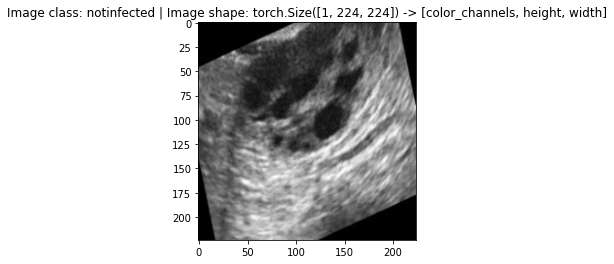

In [14]:
import matplotlib.pyplot as plt
import numpy as np
#rand_img = rand_img.permute(1,2,0)
npimg = rand_img.squeeze().numpy()
npimg = npimg / 255 
plt.imshow(npimg, cmap='gray') ##### Here I changed the original code of the vscode file b/c of newer version error
plt.title(f"Image class: {label} | Image shape: {rand_img.shape} -> [color_channels, height, width]")
plt.show()

***

# Getting a Pretrained Model

In [15]:
# Setup the model with pretrained weights and send it to the target device (torchvision v0.13+)
weights0 = torchvision.models.DenseNet201_Weights.DEFAULT # DEFAULT means best available weights for ImageNet
# weights0 = torchvision.models.DenseNet121_Weights.DEFAULT # DEFAULT means best available weights for ImageNet
model0 = torchvision.models.densenet201(weights=weights0).to(device)
# model0 = torchvision.models.densenet121(weights=weights0).to(device)
model0

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

### There are 2 problems in model0 that needs to be solved/Fine-tuned: <br> 
1. First problem: In the very first layer (conv0), the model takes an input channels of 3 b/c it is trained on colored images (ImageNet dataset) which has 3 color channels. However, your dataset consists of grayscale images which have 1 color channel so that 3 must be modified into 1. <br><br>
2. Second problem: In the very last layer (classifier), the model outputs 1000 classes since ImageNet has 1000 classes. However, your dataset only has 2 classes which are infected and notinfected, therefore the 1000 needs to be modified into 2.

In [16]:
# Print a summary using torchinfo 
summary(model=model0,
        input_size=(32,3,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 3, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 3, 224, 224]    [32, 1920, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 3, 224, 224]    [32, 64, 112, 112]   9,408                True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]    

## 1. Fine tuning and adjusting the very first layer

In [17]:
print(model0.features.conv0) # We need to modify this

Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)


In [18]:
# Adjusting input channels from 3 to 1 to match grayscale images color channels
# model0.features.conv0 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
conv_weight = model0.features.conv0.weight

In [19]:
model0.features.conv0.in_channels = 1

In [20]:
model0.features.conv0.weight = torch.nn.Parameter(conv_weight.sum(dim=1, keepdim=True))

In [21]:
model0

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [22]:
# Print a summary using torchinfo 
summary(model=model0,
        input_size=(32,1,224,224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 1, 224, 224]    [32, 1000]           --                   True
├─Sequential (features)                       [32, 1, 224, 224]    [32, 1920, 7, 7]     --                   True
│    └─Conv2d (conv0)                         [32, 1, 224, 224]    [32, 64, 112, 112]   3,136                True
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   128                  True
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   True
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 56]    

# 2. Freezing the Feature Extractor & Adjusting the Very Last Layer (output layer)

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [23]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model0.features.parameters():
  param.requires_grad = False

In [24]:
# Now adjusting the output layer
model0.classifier # original classifier

Linear(in_features=1920, out_features=1000, bias=True)

In [25]:
# New adjusted classifier
torch.manual_seed(42)
torch.cuda.manual_seed(42)
output_shape = 1

in_features = model0.classifier.in_features
model0.classifier = nn.Linear(in_features=in_features, out_features=output_shape, bias=True)
# model0.classifier = nn.Sequential(
#     nn.Linear(1024, 10),
#     nn.Linear(10, output_shape)
# )

In [26]:
# Do a summary *after* freezing the features and changing the output classifier layer (uncomment for actual output)
summary(model0, 
        input_size=(32, 1, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 1, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                       [32, 1, 224, 224]    [32, 1920, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 1, 224, 224]    [32, 64, 112, 112]   (3,136)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

In [27]:
model0 = model0.to(device)

***

# Training the Model:

In [28]:
# Define loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.01)

In [29]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model0,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=15,
                       device=device)

# End the timer and print how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6522 | train_acc: 0.6217 | test_loss: 0.7059 | test_acc: 0.5240
Epoch: 2 | train_loss: 0.5771 | train_acc: 0.7188 | test_loss: 0.6775 | test_acc: 0.6289
Epoch: 3 | train_loss: 0.4955 | train_acc: 0.8931 | test_loss: 0.6536 | test_acc: 0.6406
Epoch: 4 | train_loss: 0.4496 | train_acc: 0.8898 | test_loss: 0.6277 | test_acc: 0.6752
Epoch: 5 | train_loss: 0.4102 | train_acc: 0.9326 | test_loss: 0.6270 | test_acc: 0.6239
Epoch: 6 | train_loss: 0.3819 | train_acc: 0.9211 | test_loss: 0.6113 | test_acc: 0.6646
Epoch: 7 | train_loss: 0.3634 | train_acc: 0.9391 | test_loss: 0.6144 | test_acc: 0.6546
Epoch: 8 | train_loss: 0.3225 | train_acc: 0.9638 | test_loss: 0.6076 | test_acc: 0.6646
Epoch: 9 | train_loss: 0.3049 | train_acc: 0.9671 | test_loss: 0.6048 | test_acc: 0.6842
Epoch: 10 | train_loss: 0.2927 | train_acc: 0.9688 | test_loss: 0.6182 | test_acc: 0.6719
Epoch: 11 | train_loss: 0.2856 | train_acc: 0.9507 | test_loss: 0.6100 | test_acc: 0.6802
Epoch: 12 | train_l

***

# Model Evaluation:
Plotting the loss curves to see what the training looks like over time:
We can plot the loss curves using the function `plot_loss_curves()` created in `helper_functions.py` script.

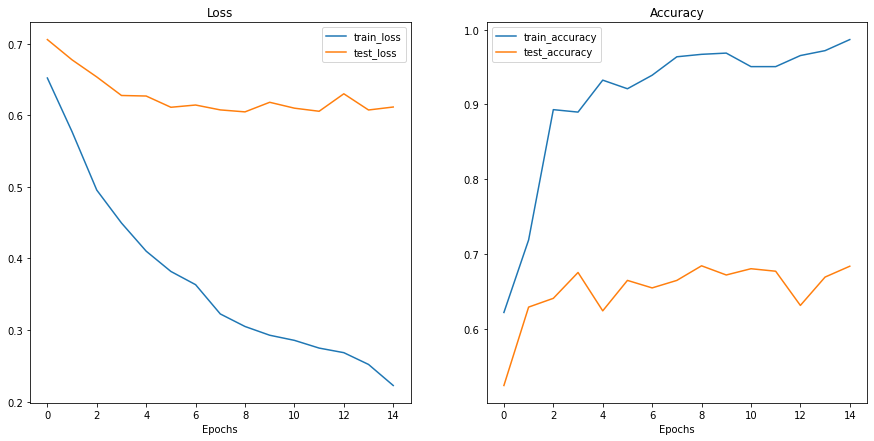

In [30]:
# Get the plot_loss_curves() funtion from helper_functions.py
from driveG.MyDrive.GP1.Graduation_Project_PCOS.going_modular import helper_functions

helper_functions.plot_loss_curves(results)

***

# Making predictions on images from the test set


### Making predictions with our model on images from the test set which are not seen during training or validation and plotting them. <br> For our model to make predictions on an image, the image has to be in the same format as the images our model was trained on. <br> To do all of this, I'll create a function `pred_and_plot()` to:
1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform, and a target device.
2. Open an image with PIL.Image.open()
3. Set the transforms to the `manual_transforms()` we created for preprocessing.
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` and the inference mode context manager.
6. Transform the target image with the transform made in the step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.sigmoid()`
9. Convert the model's prediction probabilities to prediction labels with `torch.round()`
10. Plot the image with matplotlib and set the title to prediction label from step 9 and prediction probability from step 8.

In [31]:
from typing import List, Tuple
from PIL import Image

# 1. Take in a trained model, class names, image path, image size, and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        transform: torchvision.transforms,
                        device: torch.device=device):
  # 2. Open image
  print(image_path)
  img = Image.open(image_path).convert('RGB') ##### I ADDED .convert('RGB') a5r shi b/c it solved this error with some images: RuntimeError :The size of tensor a (4) must match the size of tensor b (3) at non-singleton dimension 0
  print(f"IMG SHAPE: {img.size}")

  # 3. set transform
  image_transform = transform

  ### Predict on image ###

  # 4. Make sure the model is on the target device
  model.to(device)

  # 5. Turn on model evaluation mode and inference mode
  model.eval()
  with torch.inference_mode():
    # 6. Transform and add an extra dimemsion to image (model requires samples in [batch_size, color_channels, height, width])
    transformed_image = image_transform(img).unsqueeze(dim=0)

    # 7. Make a prediction on image with an extra dimension and send it to the target device
    target_image_pred = model(transformed_image.to(device)).squeeze()

  print(f"Pred Logit: {target_image_pred} | Type: {target_image_pred.dtype}")
  # 8. Convert Logits -> prediction probabilities (using torch.sigmoid() for binary-classification)
  target_image_pred_probs = torch.sigmoid(target_image_pred)
  print(f"Pred Prob: {target_image_pred_probs} | Type: {target_image_pred_probs.dtype}")

  # 9. Conver prediction probabilities -> prediction labels
  target_image_pred_label = torch.round(target_image_pred_probs)
  print(f"Pred label: {target_image_pred_label} | Type: {target_image_pred_label.dtype}\n\n")

  # 10. Plot image with predicted label and probability
  plt.figure()
  plt.imshow(img, cmap='gray')
  if class_names[target_image_pred_label.type(torch.int64)] == image_path.parent.stem: ########
    plt.title(f"Pred: {class_names[target_image_pred_label.type(torch.int64)]} | Truth: {image_path.parent.stem} | Prob: {target_image_pred_probs.max():.3f}", c="g")
  else:
    plt.title(f"Pred: {class_names[target_image_pred_label.type(torch.int64)]} | Truth: {image_path.parent.stem} | Prob: {target_image_pred_probs.max():.3f}", c="r")
 
  plt.axis(False);

### Let's test it out by making predictions on a few random images from the test set. <br> We can get a list of all the test image paths using `list(Path(test_dir).glob("*/*.jpg"))`, the stars in the `glob()` method say "any file matching this pattern", in other words, any file ending in `.jpg` (all of our images).<br> And then we can randomly sample a number of these using Python's [`random.sample(populuation, k)`](https://docs.python.org/3/library/random.html#random.sample) where `population` is the sequence to sample and `k` is the number of samples to retrieve.

In [32]:
# Get a random list of image paths from test set
import random

test_path = Path("/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/")

num_images_to_plot = 7
test_image_path_list = list(Path(test_path).glob("*/*.jpg")) # get all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k = num_images_to_plot) # randomly select 'k' image paths to pred and plot
                                       
test_image_path_sample

[PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/22_pco_1.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/7_normal_34.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_25.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/4_normal_38.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_31.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/9_normal_21.jpg'),
 PosixPath('/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/6_normal_21.jpg')]

/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/22_pco_1.jpg
IMG SHAPE: (300, 200)
Pred Logit: 0.2992032468318939 | Type: torch.float32
Pred Prob: 0.5742477178573608 | Type: torch.float32
Pred label: 1.0 | Type: torch.float32


/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/7_normal_34.jpg
IMG SHAPE: (300, 200)
Pred Logit: 0.8650038242340088 | Type: torch.float32
Pred Prob: 0.7037050127983093 | Type: torch.float32
Pred label: 1.0 | Type: torch.float32


/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/2_normal_25.jpg
IMG SHAPE: (300, 200)
Pred Logit: 1.131204605102539 | Type: torch.float32
Pred Prob: 0.7560611367225647 | Type: torch.float32
Pred label: 1.0 | Type: torch.float32


/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/notinfected/4_normal_38.jpg
IMG SHAPE: (300, 200)
Pred Log

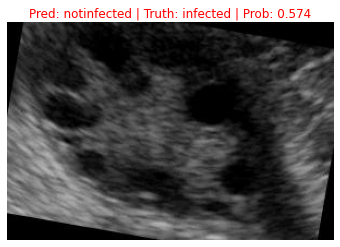

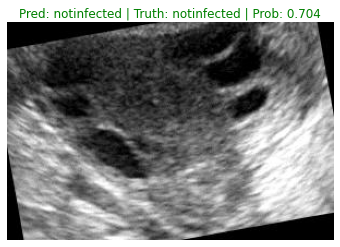

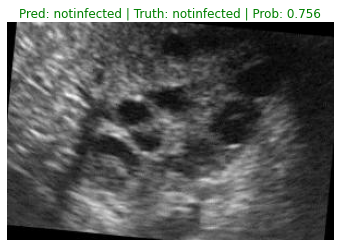

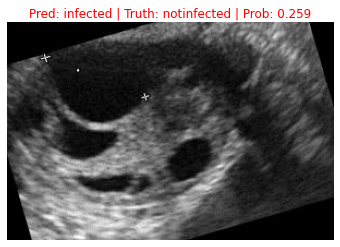

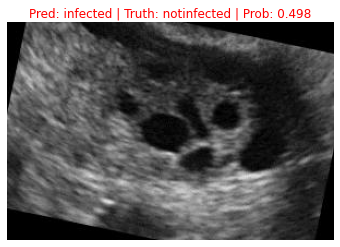

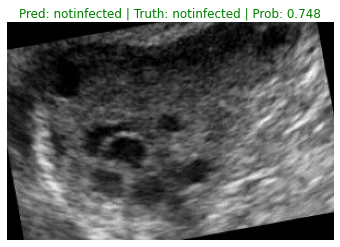

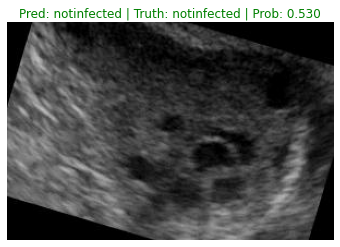

In [33]:
 # Make predictions on and plot the images
for image_path in test_image_path_sample:
  pred_and_plot_image(model=model0,
                      image_path=image_path,
                      class_names=class_names,
                      transform=manual_transforms)

/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/0_pco_13.jpg
IMG SHAPE: (300, 200)
Pred Logit: 0.31692686676979065 | Type: torch.float32
Pred Prob: 0.5785751342773438 | Type: torch.float32
Pred label: 1.0 | Type: torch.float32




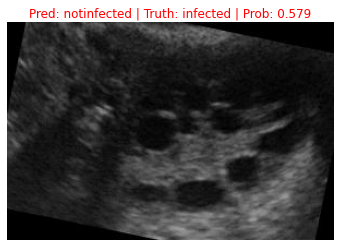

In [34]:
# Predicting on a single image by passing its path
custom_image_path = "/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/0_pco_13.jpg"
custom_image_path = Path(custom_image_path)
pred_and_plot_image(model=model0,
                    image_path=custom_image_path,
                    class_names=class_names,
                    transform=manual_transforms)

***

# Plotting the Confusion Matrix:

In [35]:
!pip install torchmetrics -U mlxtend # we need mlxtend to plot the condusion matrix
import torchmetrics, mlxtend
print(f"mlxtend version {mlxtend.__version__}") # must be version 0.19.0 or higher

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 512.4/512.4 KB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.2 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.14.0
    Uninstalling mlxtend-0.14.0:
      Successfully uninstalled mlxtend-0.14.0
mlxtend version 0.21.0


## 1. Make Predictions on the entire test data loader using the trained model:

In [36]:
from tqdm.auto import tqdm
y_preds = [] # list for storing the model predictions
y_targets = [] # list for storing the true labels of the test data
model0.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making Predictions..."): # X and y are the image and label batches in the test dataloader
    # Send data and labels to target device
    X, y = X.to(device), y.to(device)
    # Add the true labels to the y_targets list
    y_targets.append(y.cpu())
    # Do the forward pass on one batch
    y_logit = model0(X).squeeze()
    # Turn predictions from logits -> prediction probabilities -> prediction labels
    y_pred = torch.round(torch.sigmoid(y_logit))
    # append to y_preds list & Put prediction on CPU for evaluation
    y_preds.append(y_pred.cpu()) # must be on CPU in order to be visualized

y_pred_tensor = torch.cat(y_preds) # concatenating all the prediction tensors into a single prediction tensor
y_target_tensor = torch.cat(y_targets)
y_pred_tensor[:10], y_target_tensor[:10]

Making Predictions...:   0%|          | 0/8 [00:00<?, ?it/s]

(tensor([0., 1., 0., 0., 1., 0., 0., 0., 0., 0.]),
 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

## 2. Making a confusion matrix:

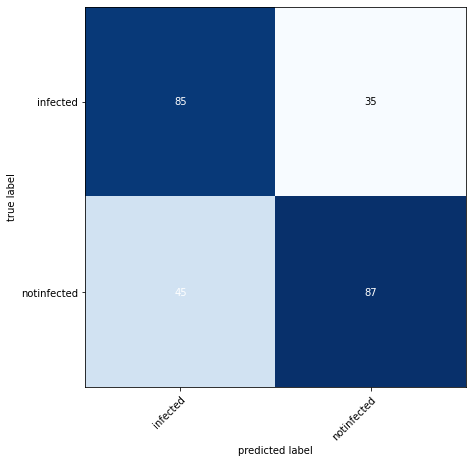

In [37]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(task="binary", num_classes=len(class_names))
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=y_target_tensor)

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), 
    class_names=class_names,
    figsize=(10, 7)
)

***

# Saving the model: (Method 1)

In [38]:
FILE = "/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/DenseNet201_model0.pth"
torch.save(model0, FILE)

## Reloading and using the saved model:

In [39]:
model0_Reloaded = torch.load(FILE)
#model0_Reloaded.eval()

summary(model0_Reloaded, 
        input_size=(32, 1, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
DenseNet (DenseNet)                           [32, 1, 224, 224]    [32, 1]              --                   Partial
├─Sequential (features)                       [32, 1, 224, 224]    [32, 1920, 7, 7]     --                   False
│    └─Conv2d (conv0)                         [32, 1, 224, 224]    [32, 64, 112, 112]   (3,136)              False
│    └─BatchNorm2d (norm0)                    [32, 64, 112, 112]   [32, 64, 112, 112]   (128)                False
│    └─ReLU (relu0)                           [32, 64, 112, 112]   [32, 64, 112, 112]   --                   --
│    └─MaxPool2d (pool0)                      [32, 64, 112, 112]   [32, 64, 56, 56]     --                   --
│    └─_DenseBlock (denseblock1)              [32, 64, 56, 56]     [32, 256, 56, 56]    --                   False
│    │    └─_DenseLayer (denselayer1)         [32, 64, 56, 56]     [32, 32, 56, 

### We can see that the reloaded model is the exact same one as the one we trained. Let's make sure by predicting on the same image that we predicting on using model0, the Prob must match!

/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/0_pco_13.jpg
IMG SHAPE: (300, 200)
Pred Logit: 0.31692686676979065 | Type: torch.float32
Pred Prob: 0.5785751342773438 | Type: torch.float32
Pred label: 1.0 | Type: torch.float32




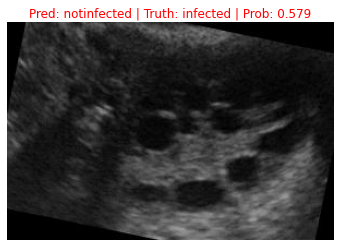

In [40]:
custom_image_path2 = "/content/driveG/MyDrive/GP1/After_Research_paper/DenseNet_Reimagined/newER_data/validation/infected/0_pco_13.jpg"
custom_image_path2 = Path(custom_image_path2)
pred_and_plot_image(model=model0_Reloaded,
                    image_path=custom_image_path2,
                    class_names=class_names,
                    transform=manual_transforms)

### As we can see it is the exact same prediction prob as before so it is definitely the same model.